In [1]:
%autosave 0
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

from datetime import date, timedelta
from joblib import dump

import warnings
warnings.filterwarnings("ignore") 

Autosave disabled


Start Day : 28/03

Trying to predict number of new cases & deaths one day before

Working with data update everyday here : https://ourworldindata.org/coronavirus-source-data
I take the full dataset linked

In [2]:
## Today Data scrap on nb 00 
df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")

In [3]:
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498


In [4]:
df.tail(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
43913,NaN,NaN,International,2020-09-13,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43914,NaN,NaN,International,2020-09-14,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43915,NaN,NaN,International,2020-09-15,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['location'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus',
       'Czech Republic', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Ethiopia', 'Faeroe Islands', 'Falkland Isla

# Data Exploration

In [6]:
def massBalance(subject,df,country):
    """ Plot evolution of data by columns
    params :
        subject = name of cols concerned by the plot
        df = The Dataframe
        country = Name of location isolated for the plot
    """
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.line(x=df["date"], y=df[f"{subject}"])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [7]:
## Plotly graph will be not display on Git ##
# massBalance("total_deaths",df,"World")
# massBalance("total_deaths",df,"France")
# massBalance("total_deaths",df,"China")
# massBalance("total_deaths",df,"Italy")
# massBalance("total_deaths",df,"Spain")
# massBalance("total_deaths",df,"United States")
# massBalance("total_deaths",df,"Germany")
# massBalance("total_deaths",df,"Iran")
# massBalance("total_deaths",df,"Turkey")
# massBalance("total_deaths",df,"Brazil")

In [8]:
## Plotly graph will be not display on Git ##
# massBalance("total_cases",df,"World")
# massBalance("total_cases",df,"France")
# massBalance("total_cases",df,"China")
# massBalance("total_cases",df,"Italy")
# massBalance("total_cases",df,"Spain")
# massBalance("total_cases",df,"United States")
# massBalance("total_cases",df,"United Kingdom")
# massBalance("total_cases",df,"Germany")
# massBalance("total_cases",df,"Iran")
# massBalance("total_cases",df,"Turkey")
# massBalance("total_cases",df,"Brazil")

In [9]:
def newOverTime(subject,df,country):
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.bar(df, x=df["date"], y=df[f'{subject}'])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [10]:
## Plotly graph will be not display on Git ##
# newOverTime("new_cases",df,"World")
# newOverTime("new_cases",df,"France")
# newOverTime("new_cases",df,"China")
# newOverTime("new_cases",df,"Italy")
# newOverTime("new_cases",df,"Spain")
# newOverTime("new_cases",df,"United States")
# newOverTime("new_cases",df,"United Kingdom")
# newOverTime("new_cases",df,"Germany")
# newOverTime("new_cases",df,"Iran")
# newOverTime("new_cases",df,"Turkey")
# newOverTime("new_cases",df,"Brazil")

In [11]:
## Plotly graph will be not display on Git ##
# newOverTime("new_deaths",df,"World")
# newOverTime("new_deaths",df,"France")
# newOverTime("new_deaths",df,"China")
# newOverTime("new_deaths",df,"Italy")
# newOverTime("new_deaths",df,"Spain")
# newOverTime("new_deaths",df,"United States")
# newOverTime("new_deaths",df,"United Kingdom")
# newOverTime("new_deaths",df,"Germany")
# newOverTime("new_deaths",df,"Iran")
# newOverTime("new_deaths",df,"Turkey")
# newOverTime("new_deaths",df,"Brazil")

In [12]:
def worldrep(subject,graph_long=5,val_larg=1000000,df=df):
    fidf_mod = df.sort_values(subject, axis=0, ascending =False).head(500)
    f, ax = plt.subplots(figsize=(15, graph_long))

    ax.set(xlim=(0, val_larg), 
           ylabel= "Pays",
           xlabel= subject,
           Title= (f"{subject} by country")
          )
    ax.legend()
    sns.despine(top=True)
    ax = sns.barplot(x=fidf_mod[subject], y=fidf_mod["location"])


No handles with labels found to put in legend.


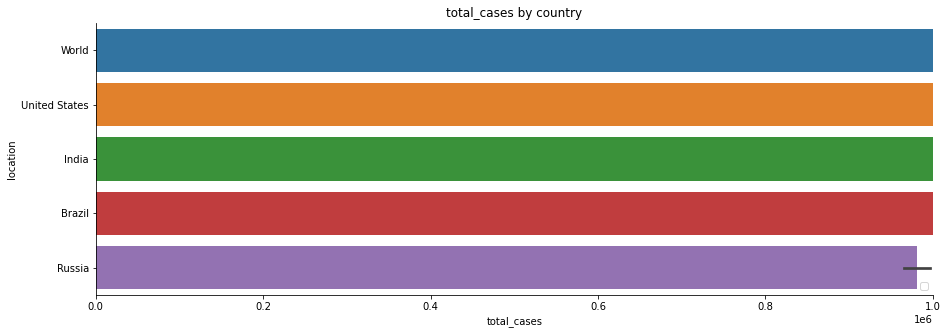

In [13]:
worldrep("total_cases")

No handles with labels found to put in legend.


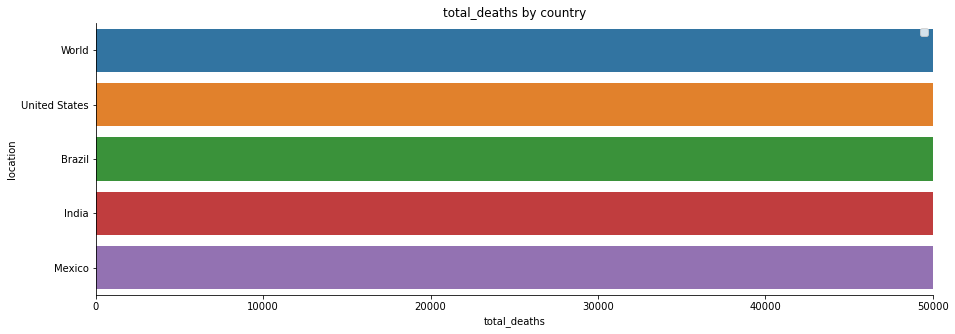

In [14]:
worldrep("total_deaths",val_larg=50000)

In [15]:
dds = df[df["date"].isin([f'{date.today()}'])]

No handles with labels found to put in legend.


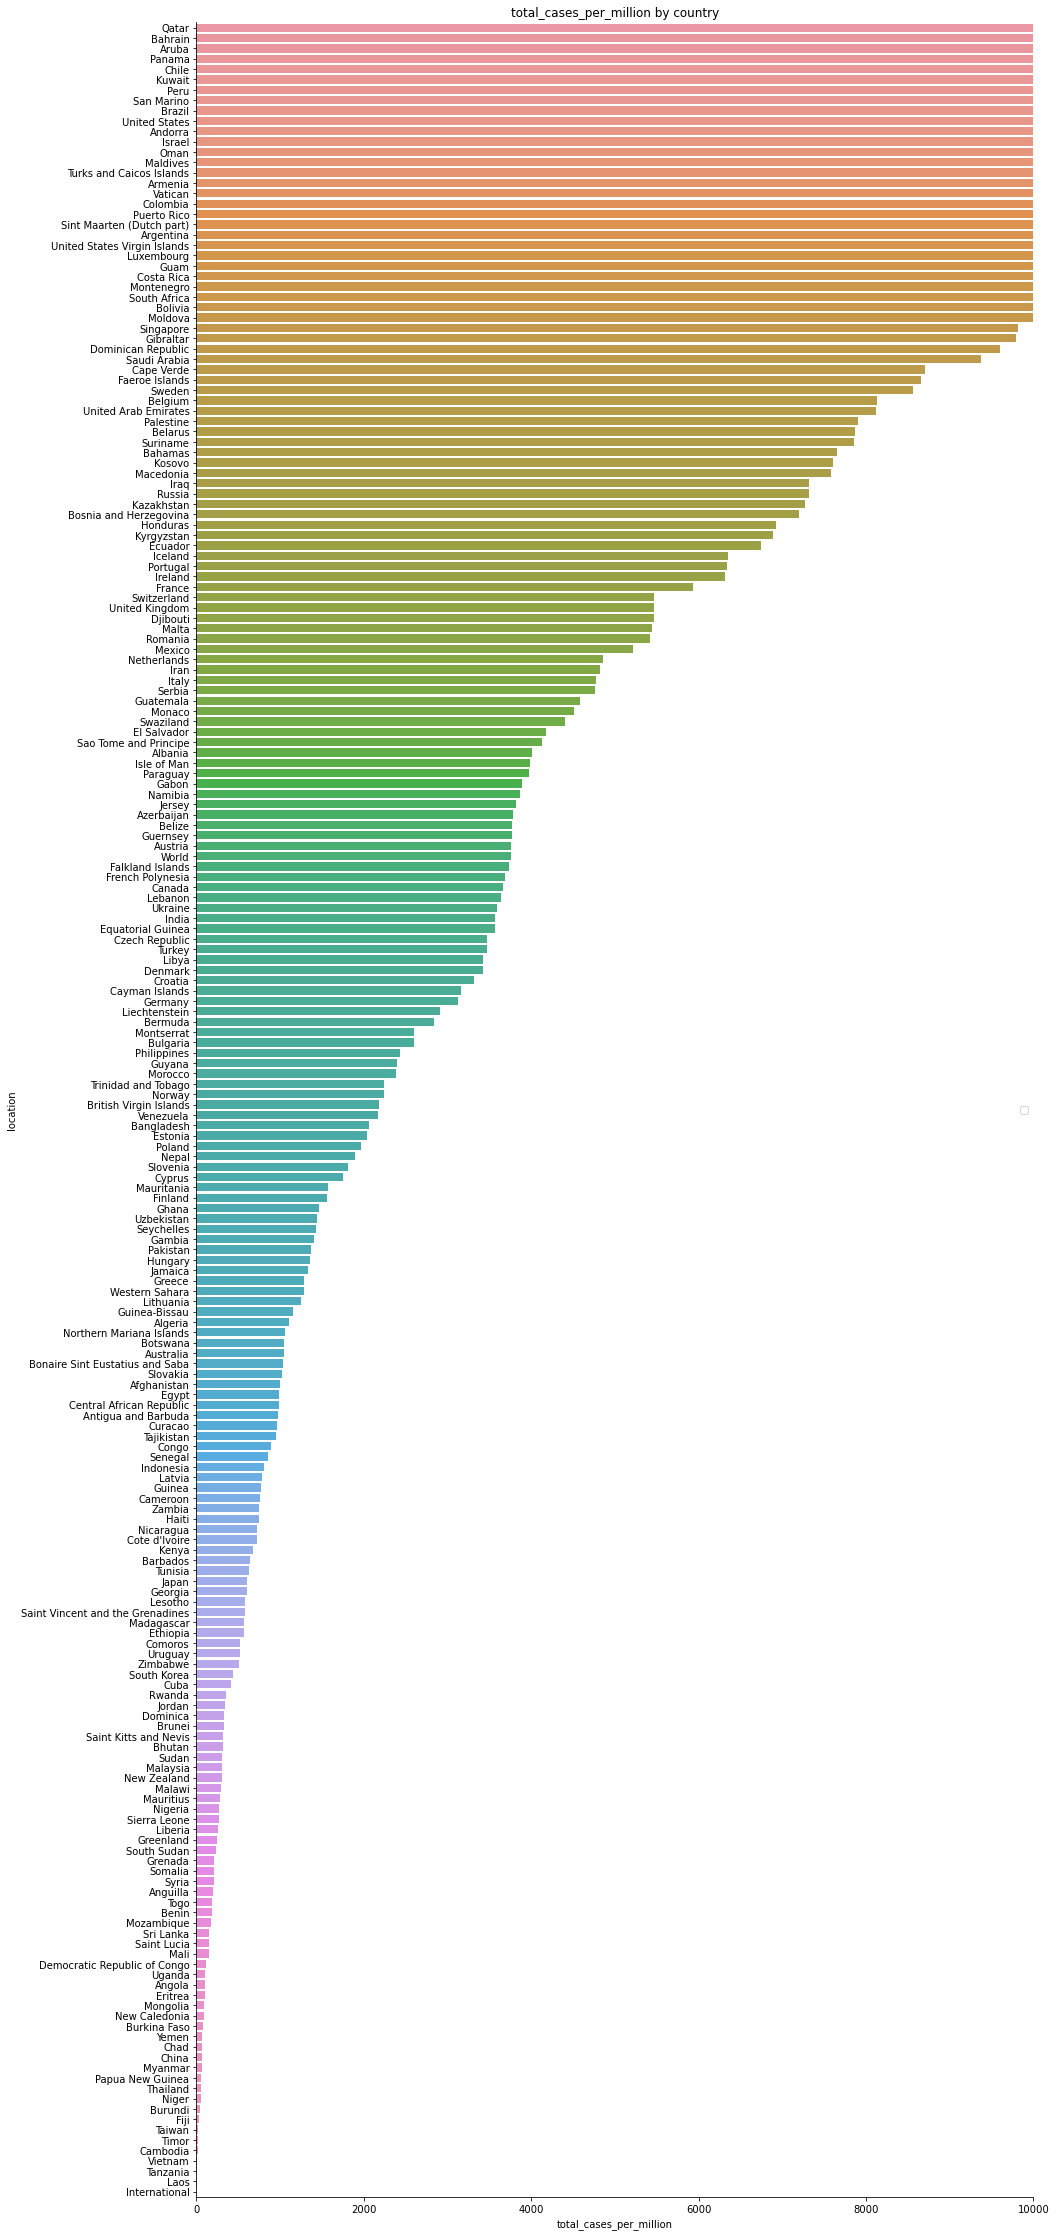

In [16]:
try:
    worldrep("total_cases_per_million",graph_long=40,val_larg=10000,df=dds)
except:
    print("Not today")

No handles with labels found to put in legend.


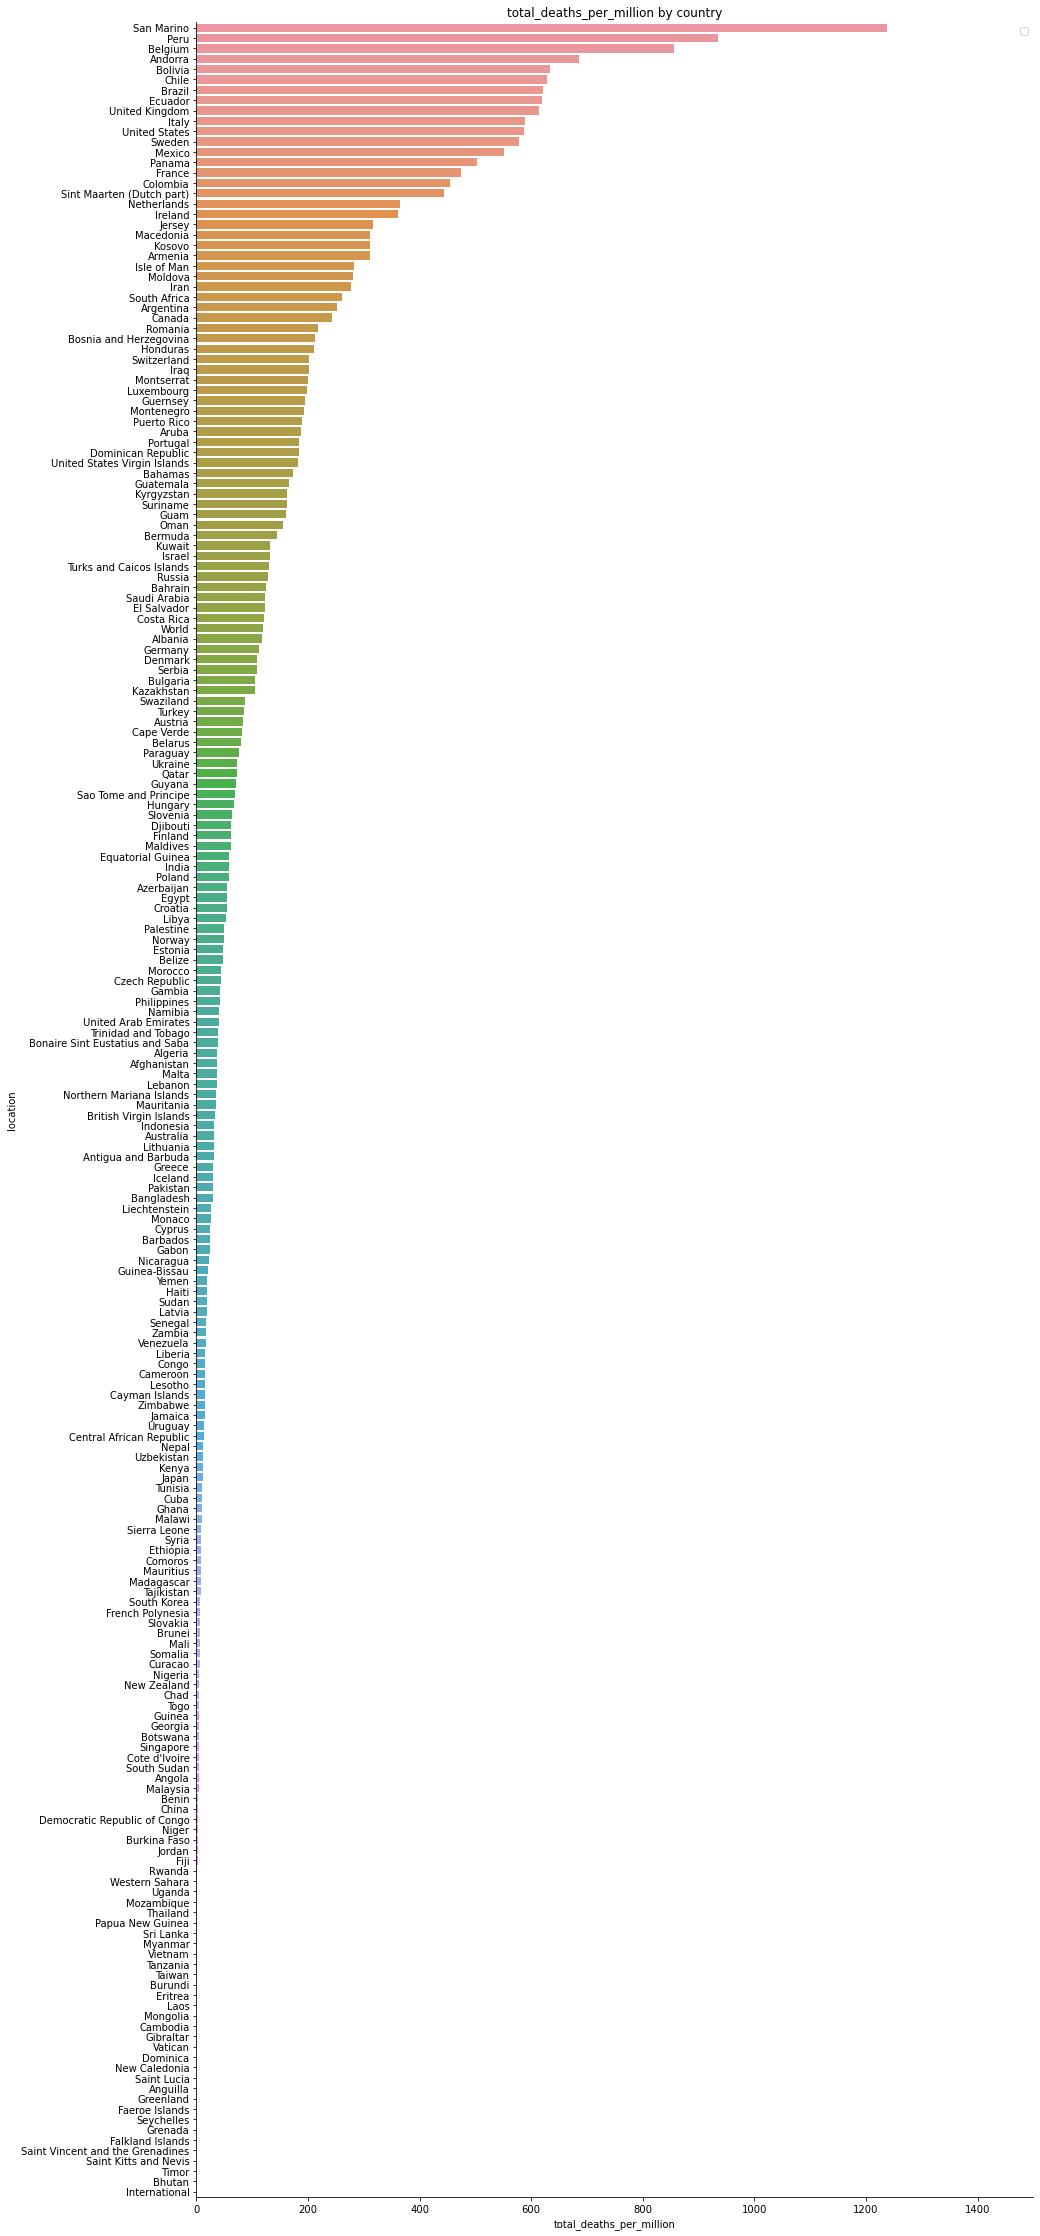

In [17]:
try :
    worldrep("total_deaths_per_million",graph_long=40,val_larg=1500,df=dds)
    is_full_data = True
except:
    is_full_data = False
    print("not today")

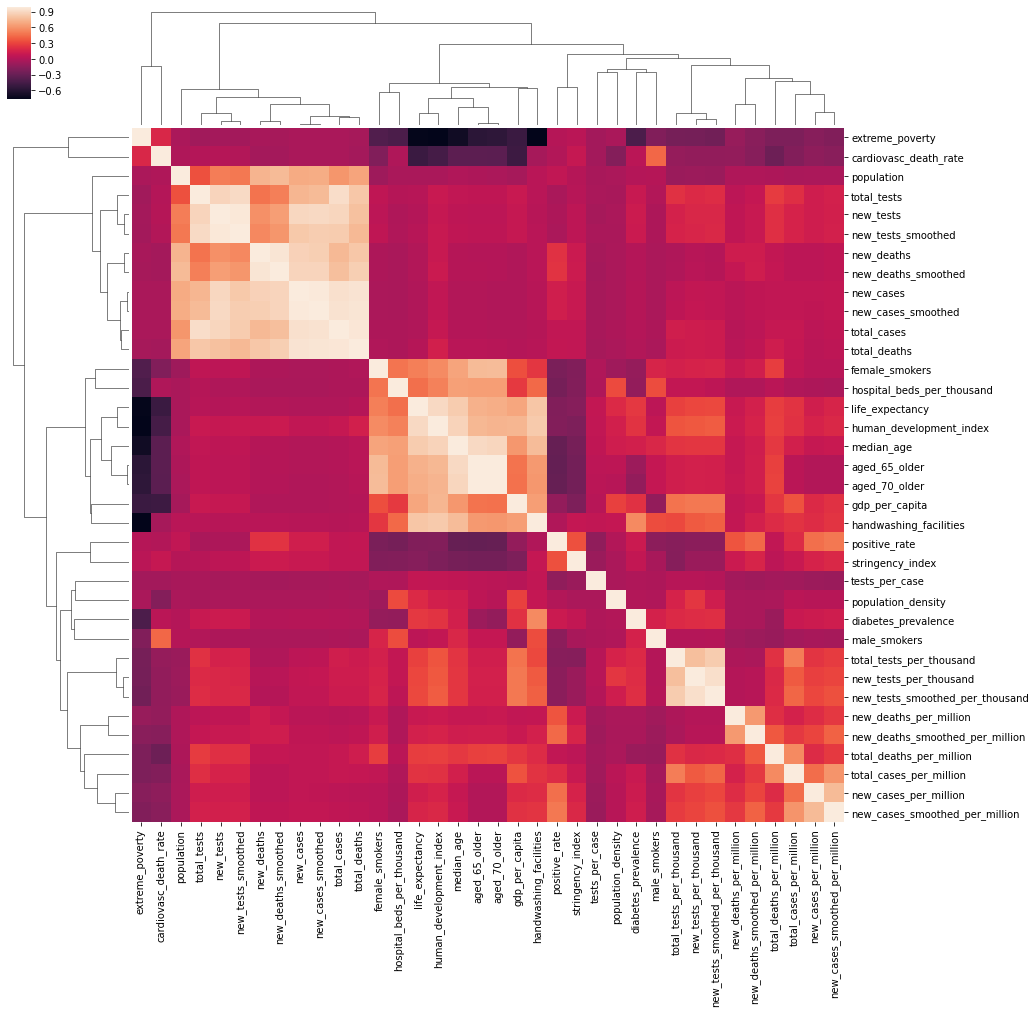

In [18]:
if is_full_data:
    corr = df.corr()
    sns.clustermap(corr,figsize=(15, 15))
else :
    print("not today")

# Modeling routines

In [19]:
def createModel(subject,periode,country,n_splits=3,max_iter=5000):
    
    df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")
    df = df[df['location'].isin([f"{country}"])] 
    vals = df[[f"{subject}"]].values
    
    imp = SimpleImputer(missing_values=np.nan, strategy='constant')
    vals = imp.fit_transform(vals)
    
    hisShape = vals.shape[0]
    x_train = []
    y_train = []

    for i in range(periode,hisShape):
        x_train.append(vals[(i-periode):i,0]) 
        y_train.append(vals[i,0])

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    ###############################################################
    model = ElasticNet(random_state=0,max_iter=max_iter) 
    # tol=0.01 by reducing this hp warning disapear, pred will be highter 
    ###############################################################
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = cross_val_score(model, x_train, y_train, cv=tscv)
    print(f"R^2: {scores.mean()} (+/- {scores.std()})")
    
    model.fit(x_train,y_train)
    print("Coef : ",model.coef_)
    
    return vals, x_train,y_train, model

In [20]:
def predicTomorow(vals,model,periode):
    tmw = vals[-periode:]
    lili = []
    for i in tmw:
        lili.append(int(i))
    lili = np.array(lili).reshape(1, -1) 
    res = int(model.predict(lili))
    last_day = lili[0][periode-1]
    diff_betw = res-last_day
    print(f"{periode} Last_days : ",lili)
    print("Today : ",last_day)
    print("Prediction + : ",diff_betw)
    print("Tomorow : ",res)
    return last_day, res

In [21]:
def conbine(subject,periode,country):
    vals, x_train, y_train, model = createModel(subject,periode,country)
    last_day, ress = predicTomorow(vals,model,periode)
    return last_day, ress

In [22]:
def fullRoutines(df,periode,country):
    print(f"********* For {country} **************")
    print("                                     ")
    print("--------- Total Cases -----------------")
    print("                                     ")
    last_day_cases, res1 = conbine("total_cases",periode,f"{country}")
    print("                                     ")
    print("--------- Total Death -----------------")
    print("                                     ")
    last_day_death, res2 = conbine("total_deaths",periode,f"{country}")
    print("                                     ")
    return last_day_cases, last_day_death, res1, res2

# Prediction Tomorow

In [23]:
periode = 3

In [24]:
last_day_cases, last_day_death, res1ww, res2ww = fullRoutines(df,periode,"World")
world_data = last_day_cases, last_day_death, res1ww, res2ww

********* For World **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9988389729208057 (+/- 0.001400504905858891)
Coef :  [1.03314233e+00 8.82044420e-05 9.14902420e-05]
3 Last_days :  [[28805768 29078057 29309546]]
Today :  29309546
Prediction + :  553823
Tomorow :  29863369
                                     
--------- Total Death -----------------
                                     
R^2: 0.9996636928702648 (+/- 0.00010705772330745306)
Coef :  [0.16846765 0.4077167  0.4339793 ]
3 Last_days :  [[920937 924815 928890]]
Today :  928890
Prediction + :  9522
Tomorow :  938412
                                     


In [25]:
last_day_casesfr, last_day_deathfr, res1fr, res2fr = fullRoutines(df,periode,"France")
french_data = last_day_casesfr, last_day_deathfr, res1fr, res2fr

********* For France **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.8928481636748877 (+/- 0.1477341697435126)
Coef :  [-0.74858367  0.7881321   0.96428654]
3 Last_days :  [[373911 381094 387252]]
Today :  387252
Prediction + :  6659
Tomorow :  393911
                                     
--------- Total Death -----------------
                                     
R^2: 0.9547513499045847 (+/- 0.05465812099376813)
Coef :  [-0.74875468  0.78847291  0.95924965]
3 Last_days :  [[30910 30916 30950]]
Today :  30950
Prediction + :  24
Tomorow :  30974
                                     


In [26]:
last_day_casesch, last_day_deathch, res1ch, res2ch = fullRoutines(df,periode,"China")
china_data = last_day_casesch, last_day_deathch, res1ch, res2ch

********* For China **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9494410326867772 (+/- 0.04458059460116499)
Coef :  [-0.32834939 -0.01320869  1.33582376]
3 Last_days :  [[90168 90197 90219]]
Today :  90219
Prediction + :  27
Tomorow :  90246
                                     
--------- Total Death -----------------
                                     
R^2: -90.80831411710079 (+/- 129.7323921342434)
Coef :  [-0.07742033  0.01246592  1.05672685]
3 Last_days :  [[4734 4734 4735]]
Today :  4735
Prediction + :  5
Tomorow :  4740
                                     


In [27]:
last_day_casesit, last_day_deathit, res1it, res2it = fullRoutines(df,periode,"Italy")
italy_data = last_day_casesit, last_day_deathit, res1it, res2it

********* For Italy **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9746668511763293 (+/- 0.034714407817970125)
Coef :  [-0.81701059  0.89498372  0.92139481]
3 Last_days :  [[286297 287753 288761]]
Today :  288761
Prediction + :  1325
Tomorow :  290086
                                     
--------- Total Death -----------------
                                     
R^2: 0.7958229569431019 (+/- 0.26587760062359617)
Coef :  [-0.82278613  0.89676188  0.92505976]
3 Last_days :  [[35603 35610 35624]]
Today :  35624
Prediction + :  25
Tomorow :  35649
                                     


In [28]:
try:
    last_day_casessp, last_day_deathsp, res1sp, res2sp = fullRoutines(df,periode,"Spain")
    spain_data = last_day_casessp, last_day_deathsp, res1sp, res2sp
except:
    print("No spain update")

********* For Spain **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.6208132305941504 (+/- 0.5267631543484402)
Coef :  [-0.33439642  0.20508239  1.13570188]
3 Last_days :  [[566326 566326 593730]]
Today :  593730
Prediction + :  7464
Tomorow :  601194
                                     
--------- Total Death -----------------
                                     
R^2: -0.03138269735821816 (+/- 1.169524018547984)
Coef :  [-0.72960731  0.63852897  1.09007809]
3 Last_days :  [[29747 29747 29848]]
Today :  29848
Prediction + :  17
Tomorow :  29865
                                     


In [29]:
last_day_casesus, last_day_deathus, res1us, res2us = fullRoutines(df,periode,"United States")
usa_data = last_day_casesus, last_day_deathus, res1us, res2us

********* For United States **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.98690212768525 (+/- 0.017584149590220415)
Coef :  [0.08514173 0.45941146 0.46847189]
3 Last_days :  [[6486108 6519979 6554820]]
Today :  6554820
Prediction + :  80143
Tomorow :  6634963
                                     
--------- Total Death -----------------
                                     
R^2: 0.9987391449908117 (+/- 0.0005709550105869807)
Coef :  [-0.44585878  0.68950168  0.75901361]
3 Last_days :  [[193701 194079 194530]]
Today :  194530
Prediction + :  981
Tomorow :  195511
                                     


In [30]:
last_day_casesuk, last_day_deathuk, res1uk, res2uk = fullRoutines(df,periode,"United Kingdom")
uk_data = last_day_casesuk, last_day_deathuk, res1uk, res2uk

********* For United Kingdom **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9782870063788227 (+/- 0.029829326362038448)
Coef :  [-0.68716863  0.83152305  0.85624736]
3 Last_days :  [[365174 368504 371125]]
Today :  371125
Prediction + :  2709
Tomorow :  373834
                                     
--------- Total Death -----------------
                                     
R^2: 0.2941627735578356 (+/- 0.9562022625824372)
Coef :  [-0.7668499   0.83067361  0.93546447]
3 Last_days :  [[41623 41628 41637]]
Today :  41637
Prediction + :  37
Tomorow :  41674
                                     


In [31]:
last_day_casesger, last_day_deathger, res1ger, res2ger = fullRoutines(df,periode,"Germany")
ger_data = last_day_casesger, last_day_deathger, res1ger, res2ger

********* For Germany **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9822988039076663 (+/- 0.02398005579477462)
Coef :  [-0.78345066  0.85196568  0.93127294]
3 Last_days :  [[259428 260355 261762]]
Today :  261762
Prediction + :  897
Tomorow :  262659
                                     
--------- Total Death -----------------
                                     
R^2: 0.3032944828541841 (+/- 0.975609059803492)
Coef :  [-0.78624674  0.83966595  0.94581875]
3 Last_days :  [[9349 9350 9362]]
Today :  9362
Prediction + :  6
Tomorow :  9368
                                     


In [32]:
last_day_casesIran, last_day_deathIran, res1Iran, res2Iran = fullRoutines(df,periode,"Iran")
Iran_data = last_day_casesIran, last_day_deathIran, res1Iran, res2Iran

********* For Iran **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.7855512115982966 (+/- 0.3014001892578167)
Coef :  [0.28996395 0.36150201 0.35912509]
3 Last_days :  [[399940 402029 404648]]
Today :  404648
Prediction + :  3526
Tomorow :  408174
                                     
--------- Total Death -----------------
                                     
R^2: 0.9664426349697068 (+/- 0.0468610618829409)
Coef :  [0.07945535 0.47044497 0.46082262]
3 Last_days :  [[23029 23157 23313]]
Today :  23313
Prediction + :  218
Tomorow :  23531
                                     


In [33]:
last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk = fullRoutines(df,periode,"Turkey")
Turk_data = last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk

********* For Turkey **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9995519212344526 (+/- 0.0003905568986809525)
Coef :  [-0.66960617  0.81825851  0.84872792]
3 Last_days :  [[289635 291162 292878]]
Today :  292878
Prediction + :  1209
Tomorow :  294087
                                     
--------- Total Death -----------------
                                     
R^2: 0.9993262415156172 (+/- 0.0004638227056488314)
Coef :  [-0.81249994  0.89360109  0.91674215]
3 Last_days :  [[6999 7056 7119]]
Today :  7119
Prediction + :  45
Tomorow :  7164
                                     


In [34]:
last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz = fullRoutines(df,periode,"Brazil")
Braz_data = last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz

********* For Brazil **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.982815200969393 (+/- 0.018257999586487033)
Coef :  [-0.15112651  0.51327827  0.65065287]
3 Last_days :  [[4315687 4330455 4345610]]
Today :  4345610
Prediction + :  60069
Tomorow :  4405679
                                     
--------- Total Death -----------------
                                     
R^2: 0.4717910802490586 (+/- 0.7411824329723804)
Coef :  [-0.07125322  0.50126394  0.58066695]
3 Last_days :  [[131210 131625 132006]]
Today :  132006
Prediction + :  1586
Tomorow :  133592
                                     


In [35]:
model_data = [world_data, french_data, italy_data, spain_data, usa_data,
              china_data, uk_data, ger_data, Iran_data, Turk_data, Braz_data]

In [36]:
model_data

[(29309546, 928890, 29863369, 938412),
 (387252, 30950, 393911, 30974),
 (288761, 35624, 290086, 35649),
 (593730, 29848, 601194, 29865),
 (6554820, 194530, 6634963, 195511),
 (90219, 4735, 90246, 4740),
 (371125, 41637, 373834, 41674),
 (261762, 9362, 262659, 9368),
 (404648, 23313, 408174, 23531),
 (292878, 7119, 294087, 7164),
 (4345610, 132006, 4405679, 133592)]

In [37]:
# dump(model_data, "endPoint/CovidDataPred.joblib")

In [38]:
def popPred(country,rez1,rez2):
    pop_pred = pd.DataFrame()

    pop_pred.loc[0,"date"] = date.today()
    pop_pred.loc[0,"country"] = country
    pop_pred.loc[0,"total_cases_predict"] = rez1
    pop_pred.loc[0,"total_cases_real"] = 0
    pop_pred.loc[0,"total_deaths_predict"] = rez2
    pop_pred.loc[0,"total_deaths_real"] = 0
    pop_pred.loc[0,"error_abs_cases"] = 0
    pop_pred.loc[0,"error_abs_deaths"] = 0
    
    return pop_pred

In [39]:
df_pop_pred1 = popPred("France",res1fr, res2fr)
df_pop_pred2 = popPred("China",res1ch, res2ch)
df_pop_pred3 = popPred("Italy",res1it, res2it)
df_pop_pred4 = popPred("Spain",res1sp, res2sp)
df_pop_pred5 = popPred("United States",res1us, res2us)
df_pop_pred6 = popPred("World",res1ww, res2ww)
df_pop_pred7 = popPred("United Kingdom",res1uk, res2uk)
df_pop_pred8 = popPred("Germany",res1ger, res2ger)
df_pop_pred9 = popPred("Iran",res1Iran, res2Iran)
df_pop_pred10 = popPred("Turkey",res1Turk, res2Turk)
df_pop_pred11 = popPred("Brazil",res1Braz, res2Braz)

frames = [df_pop_pred1, df_pop_pred2, df_pop_pred3, df_pop_pred4,
          df_pop_pred5, df_pop_pred6, df_pop_pred7, df_pop_pred8,
          df_pop_pred9, df_pop_pred10, df_pop_pred11]

predpred = pd.concat(frames)
predpred

,date,country,total_cases_predict,total_cases_real,total_deaths_predict,total_deaths_real,error_abs_cases,error_abs_deaths
0,2020-09-15,France,393911.0,0.0,30974.0,0.0,0.0,0.0
0,2020-09-15,China,90246.0,0.0,4740.0,0.0,0.0,0.0
0,2020-09-15,Italy,290086.0,0.0,35649.0,0.0,0.0,0.0
0,2020-09-15,Spain,601194.0,0.0,29865.0,0.0,0.0,0.0
0,2020-09-15,United States,6634963.0,0.0,195511.0,0.0,0.0,0.0
0,2020-09-15,World,29863369.0,0.0,938412.0,0.0,0.0,0.0
0,2020-09-15,United Kingdom,373834.0,0.0,41674.0,0.0,0.0,0.0
0,2020-09-15,Germany,262659.0,0.0,9368.0,0.0,0.0,0.0
0,2020-09-15,Iran,408174.0,0.0,23531.0,0.0,0.0,0.0
0,2020-09-15,Turkey,294087.0,0.0,7164.0,0.0,0.0,0.0


In [40]:
predpred.to_csv(f"AzureSC\\Pred\\predDf{date.today()}.csv")